In [1]:
import collections
import math
import os
import random
import zipfile
from six.moves import urllib
from six.moves import xrange
import numpy as np
import tensorflow as tf

/Users/i550012/virtualenv/tensorflow1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/i550012/virtualenv/tensorflow1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/i550012/virtualenv/tensorflow1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/i550012/virtualenv/tensorflow1

In [2]:
DOWNLOADED_FILENAME = 'SampleText.zip'
def maybe_download(url_path, expected_bytes):
    if not os.path.exists(DOWNLOADED_FILENAME):
        filename, _ = urllib.request.urlretrieve(url_path, DOWNLOADED_FILENAME)
    statinfo = os.stat(DOWNLOADED_FILENAME)
    if statinfo.st_size == expected_bytes:
        print("Found and verified file from the path: ", url_path)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verity file from: '+ url_path )
    

In [3]:
def read_words():
    with zipfile.ZipFile(DOWNLOADED_FILENAME) as f:
        firstfile = f.namelist()[0]
        filestring = tf.compat.as_str(f.read(firstfile))
        words = filestring.split()
    return words

In [4]:
URL_PATH = 'http://mattmahoney.net/dc/text8.zip'
FILESIZE = 31344016
maybe_download(URL_PATH, FILESIZE)

Found and verified file from the path:  http://mattmahoney.net/dc/text8.zip


In [5]:
vocabulary = read_words()

In [6]:
len(vocabulary)

17005207

In [7]:
def build_dataset(words, n_words):
    word_counts = [['UNKNOWN', -1]]
    counter = collections.Counter(words)
    word_counts.extend(counter.most_common(n_words-1))
    dictionary = dict()
    for word, _ in word_counts:
        dictionary[word] = len(dictionary)
    word_indices = list()
    unknown_count = 0
    for word in words: 
        if word in dictionary: 
            index = dictionary[word]
        else:
            index = 0
            unknown_count += 1
        word_indices.append(index)
    word_counts[0][1]=unknown_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return word_counts, word_indices, dictionary, reversed_dictionary
             

In [8]:
VOCABULARY_SIZE = 10000

word_counts, word_indices, dictionary, reversed_dictionary = build_dataset(vocabulary, VOCABULARY_SIZE)

In [9]:
word_counts[:10]

[['UNKNOWN', 1737307],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430)]

In [10]:
word_indices[:10]

[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]

In [11]:
del vocabulary

In [12]:
global_index = 0


In [13]:
def generate_batch(word_indices, batch_size, num_skips, skip_window):
    global global_index 
    assert batch_size % num_skips == 0
    assert num_skips <= 2*skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size,1), dtype=np.int32)
    span = 2*skip_window + 1 
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(word_indices[global_index])
        global_index = (global_index+1) % len(word_indices)
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span-1)
            targets_to_avoid.append(target)
            batch[i*num_skips+j] = buffer[skip_window]
            labels[i*num_skips+j, 0] = buffer[target]
        buffer.append(word_indices[global_index])
        global_index = (global_index+1)%len(word_indices)
    global_index = (global_index + len(word_indices)-span) % len(word_indices)
    return batch, labels
    
        

In [14]:
batch, labels = generate_batch(word_indices, 10,2,5)

In [15]:
batch

array([   2,    2, 3134, 3134,   46,   46,   59,   59,  156,  156],
      dtype=int32)

In [16]:
labels

array([[ 156],
       [3134],
       [  59],
       [  12],
       [ 477],
       [   6],
       [ 128],
       [ 742],
       [ 477],
       [ 195]], dtype=int32)

In [17]:
for i in range(9):
    print(reversed_dictionary[batch[i]], ":", reversed_dictionary[labels[i][0]])

of : against
of : abuse
abuse : used
abuse : as
first : class
first : a
used : early
used : working
against : class


In [18]:
global_index = 0
valid_size = 16
valid_window = 100
num_samples = 64
vaild_examples = np.random.choice(valid_window, valid_size, replace=False)

In [19]:
batch_size = 128
embedding_size = 50
skip_window = 2
num_skips = 2

In [20]:
tf.reset_default_graph()

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size,1])

In [21]:
valid_dataset = tf.constant(vaild_examples, dtype=tf.int32)

In [22]:
embeddings = tf.Variable(tf.random_uniform([VOCABULARY_SIZE, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [23]:
#weights = tf.Variable(tf.truncated_normal([VOCABULARY_SIZE, embedding_size], stddev=1.0/math.sqrt(embedding_size)))
#biases = tf.Variable(tf.zeros([VOCABULARY_SIZE]))
#hidden_out = tf.matmul(embed, tf.transpose(weights)) + biases
nce_weights = tf.Variable(tf.truncated_normal([VOCABULARY_SIZE, embedding_size], stddev=1.0/math.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([VOCABULARY_SIZE]))

In [24]:
#hidden_out

In [25]:
#train_one_hot = tf.one_hot(train_labels, VOCABULARY_SIZE)
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hidden_out, labels=train_one_hot))
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights, biases=nce_biases, labels=train_labels, inputs=embed, num_sampled=num_samples, num_classes=VOCABULARY_SIZE))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
optimiser = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

In [27]:
l2_norm = tf.sqrt(tf.reduce_mean(tf.square(embeddings),1, keep_dims=True))
normalised_embeddings = embeddings/l2_norm
valid_embeddings = tf.nn.embedding_lookup(normalised_embeddings, valid_dataset)

In [28]:
valid_embeddings

<tf.Tensor 'embedding_lookup_1/Identity:0' shape=(16, 50) dtype=float32>

In [29]:
normalised_embeddings

<tf.Tensor 'truediv:0' shape=(10000, 50) dtype=float32>

In [30]:
similarity = tf.matmul(valid_embeddings, normalised_embeddings, transpose_b=True)
init = tf.global_variables_initializer()

In [31]:
num_steps = 200001


In [34]:
with tf.Session() as sess:
    init.run()
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(word_indices, batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        _, loss_val = sess.run([optimiser, loss], feed_dict=feed_dict)
        average_loss += loss_val
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            print('average loss at step', step, ':', average_loss)
            average_loss=0
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reversed_dictionary[vaild_examples[i]]
                top_k = 8
                nearest = (-sim[i,:]).argsort()[1:top_k +1]
                log_str = 'nearest to %s:'%valid_word
                for k in xrange(top_k):
                    close_word = reversed_dictionary[nearest[k]]
                    log_str = '%s %s,'%(log_str, close_word)
                print(log_str)
            print('\n')
    final_embeddings = normalised_embeddings.eval()
            
                

average loss at step 0 : 224.58103942871094
nearest to so: chiropractic, matter, kent, afghan, gray, apart, buffer, most,
nearest to who: du, computers, farmers, seventh, inner, descartes, conan, a,
nearest to not: ambient, river, beck, compounds, locomotives, composers, conviction, bulletin,
nearest to when: abuse, complaint, statute, increased, packet, beijing, mine, arena,
nearest to all: carlos, pitched, hair, stream, produces, touch, responsibility, edward,
nearest to between: adrian, situations, costs, monarchies, throw, sleep, gradual, gorbachev,
nearest to is: diego, refer, cartoons, oral, flourished, station, anal, domains,
nearest to american: succeeded, obsolete, cdu, quantity, paradigm, costa, improving, working,
nearest to no: mrs, shallow, magical, germanic, conclusions, ic, again, images,
nearest to there: railroad, attempt, isotopes, troll, steve, me, suffering, sink,
nearest to over: floating, cliff, federal, hezbollah, travel, event, jordan, soundtrack,
nearest to kno

In [35]:
def save_words_embeddings(embeddings, word_counts):
    np.save('embeddings.npy', embeddings)
    words = [x[0] for x in word_counts]
    np.save('words.npy', words)
save_words_embeddings(final_embeddings, word_counts)

In [43]:
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More lables than embeddings'
    plt.figure(figsize=(18,18))
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x,y)
        plt.annotate(label, xy=(x,y), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
    plt.savefig(filename)
    plt.show(filename)

In [48]:
from sklearn.manifold import TSNE
NUM_PLOT_POINTS = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
low_dim_embs = tsne.fit_transform(final_embeddings[:NUM_PLOT_POINTS,:])
labels = [reversed_dictionary[i] for i in xrange(NUM_PLOT_POINTS) ]

/Users/i550012/virtualenv/tensorflow1/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/Users/i550012/virtualenv/tensorflow1/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


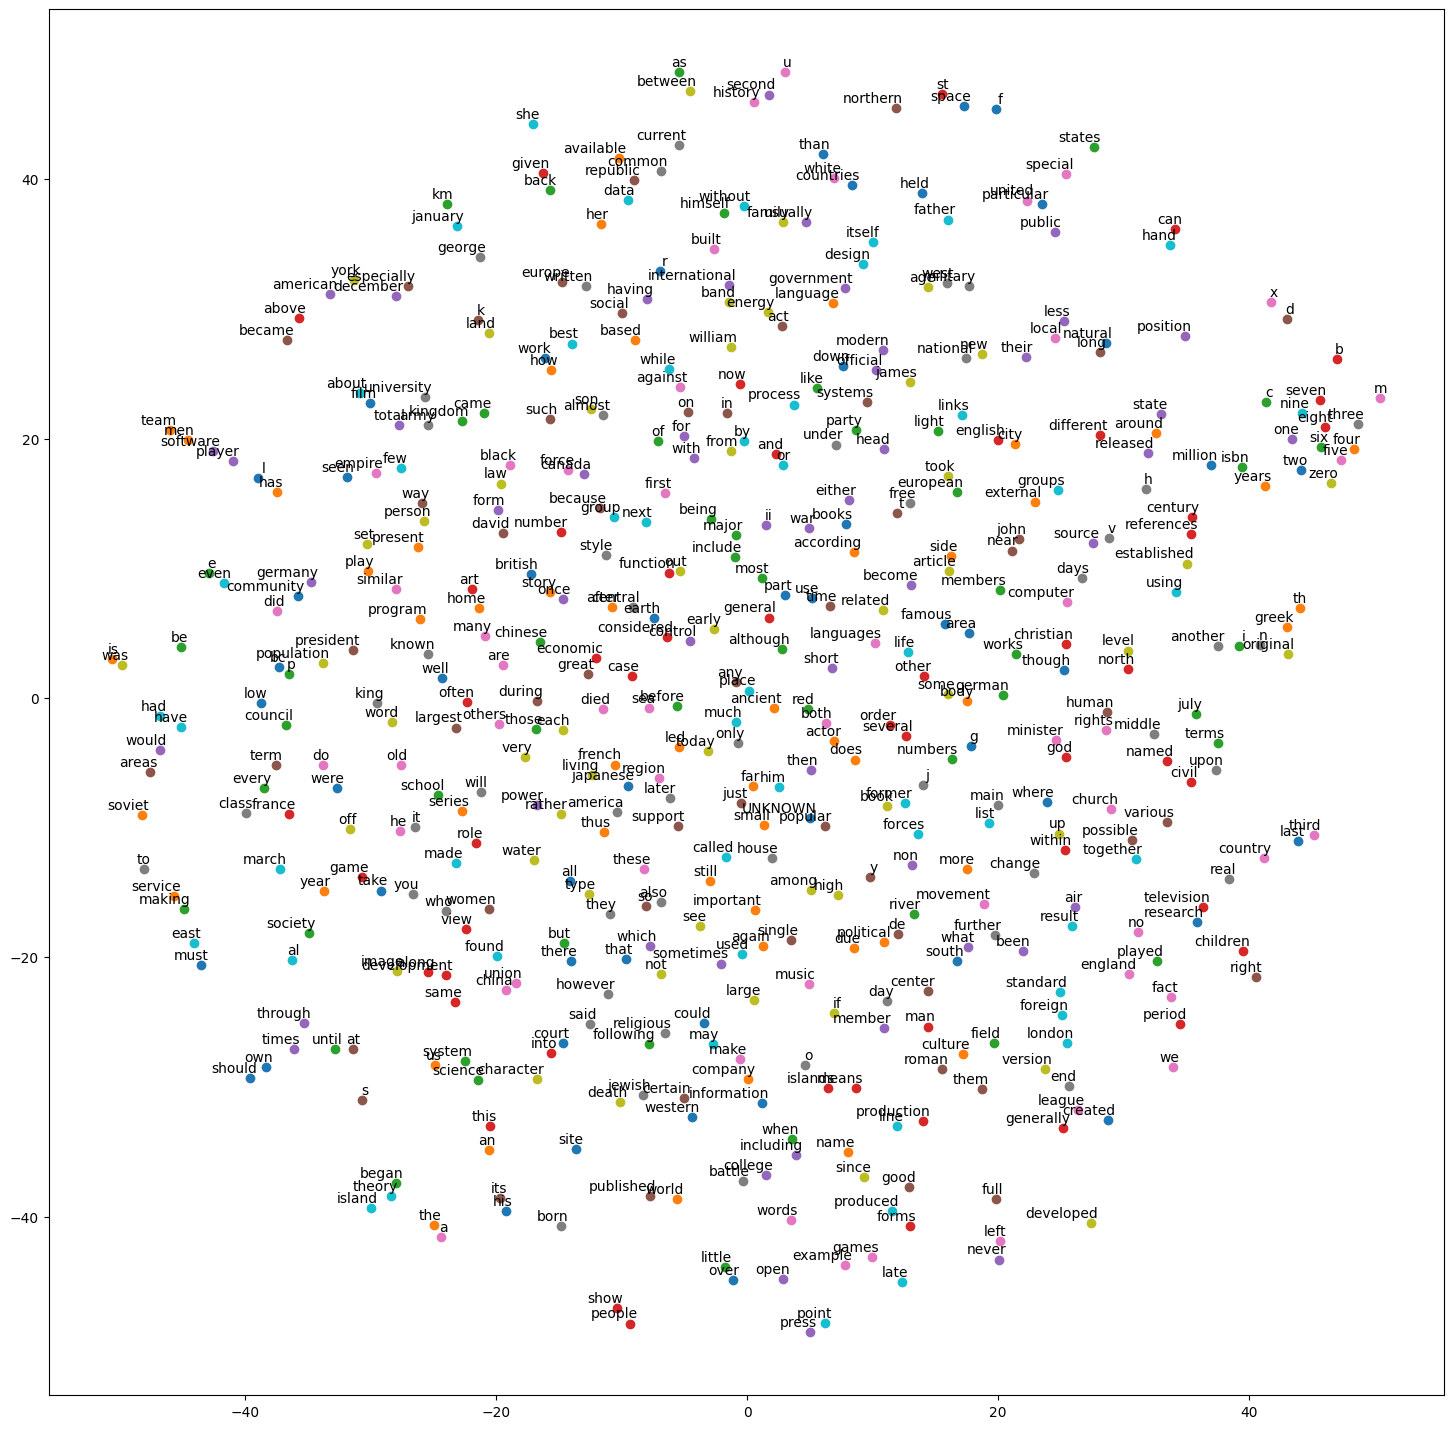

In [49]:
plot_with_labels(low_dim_embs, labels)